# Model-7

In [1]:
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer
from dataset import Dataset
from layers import *
from networks import *
from model import Model
from dbase import DataBase
from visualisation import show_similarity

In [2]:
tr_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/5557_300_128_128_1_uint8.npy"
va_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8.npy"
model_path   = "models/007/"

## Dataset

In [3]:
%%time
tr_dataset   = Dataset(tr_data_path)
va_dataset   = Dataset(va_data_path)
tr_dataset.load()
va_dataset.load()
image_shape  = list(tr_dataset.data.shape[-3:])
print("Train:", list(tr_dataset.data.shape), tr_dataset.data.dtype)
print("Valid:", list(va_dataset.data.shape), va_dataset.data.dtype)
print('-'*50)

Train: [5557, 300, 128, 128, 1] uint8
Valid: [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 256 ms, sys: 45.4 s, total: 45.7 s
Wall time: 1min 19s


## Network

In [4]:
def _VGG16(images, out_dim, reuse, training):
    use_bn = True
    l = images     # -> 128
    
    l = conv2d(l,  48, reuse, training, use_bn, name='conv_1_1')
    l = conv2d(l,  48, reuse, training, False,  name='conv_1_2')
    l = maxpool(l) # -> 64

    l = conv2d(l,  64, reuse, training, use_bn, name='conv_2_1')
    l = conv2d(l,  64, reuse, training, False,  name='conv_2_2')
    l = maxpool(l) # -> 32

    l = conv2d(l, 128, reuse, training, use_bn, name='conv_3_1')
    l = conv2d(l, 128, reuse, training, False,  name='conv_3_2')
    l = conv2d(l, 128, reuse, training, False,  name='conv_3_3')
    l = maxpool(l) # -> 16
    
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_4_1')
    l = conv2d(l, 256, reuse, training, False,  name='conv_4_2')
    l = conv2d(l, 256, reuse, training, False,  name='conv_4_3')
    l = maxpool(l) # -> 8
    
    l = conv2d(l, 512, reuse, training, use_bn, name='conv_5_1')
    l = conv2d(l, 512, reuse, training, False,  name='conv_5_2')
    l = conv2d(l, 256, reuse, training, False,  name='conv_5_3')
    l = maxpool(l) # -> 4 x 4 x 256 = 4096
    
    l = flatten(l)
    
    l = dense(l, 4096, reuse, name='fc_1')
    l = dense(l, 4096, reuse, name='fc_2')
    l = dense(l, out_dim, reuse, name='out')
    
    l = normalize(l)
    
    return l

## Build 

In [5]:
%%time
out_dims = 200
margin   = .2
network  = _VGG16

model = Model(image_shape, out_dims)
model.build(network)

CPU times: user 27.8 s, sys: 2.93 s, total: 30.7 s
Wall time: 30.7 s


## Train

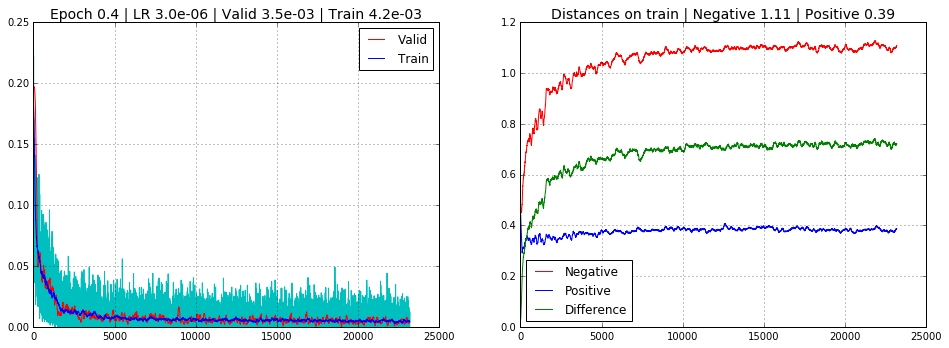

--------------------------------------------------
CPU times: user 16min 43s, sys: 3min 12s, total: 19min 55s
Wall time: 19min 8s


In [13]:
%%time
try:
    model.train(
        step_num   = 100000, 
        batch_size = 32,
        lr         = {1:1e-4, 0.02:3e-5, 0.01:1e-5, 7e-3:3e-6, 4e-3:1e-6, 3e-3:3e-7}, 
        tr_dataset = tr_dataset,
        va_dataset = va_dataset,
        margin     = margin,
        log_scale  = False)
except KeyboardInterrupt:
    pass
model.save(model_path)
print('-'*50)

## Database

In [10]:
%%time
dbase     = DataBase()
dataset   = va_dataset
ethalons  = dataset.get_ethalons()
augmented = dataset.get_augmented()
dbase.build(model, ethalons)
print("Ethalons :", list(ethalons.shape))
print("Augmented:", list(augmented.shape))
print('-'*50)

Ethalons : [550, 128, 128, 1]
Augmented: [550, 128, 128, 1]
--------------------------------------------------
CPU times: user 584 ms, sys: 356 ms, total: 940 ms
Wall time: 1.39 s


## Accuracy

In [14]:
%%time
def accuracy(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

start = timer()
ind, dist = dbase.query(augmented, 3)
t = timer() - start
n = augmented.shape[0]

print("Database   : %s" % list(dbase.images.shape))
print("Request    : %s" % list(augmented.shape))
print("Performance: %.0f img/sec" % (n/t))
print('-'*50)
for k in range(1, ind.shape[1]+1):
    print("Accuracy@%d: %.1f%%" % (k, accuracy(ind, k)))
print('-'*50)

Database   : [550, 128, 128, 1]
Request    : [550, 128, 128, 1]
Performance: 680 img/sec
--------------------------------------------------
Accuracy@1: 62.5%
Accuracy@2: 75.6%
Accuracy@3: 82.9%
--------------------------------------------------
CPU times: user 256 ms, sys: 24 ms, total: 280 ms
Wall time: 821 ms


## Search

Average distance: 0.34


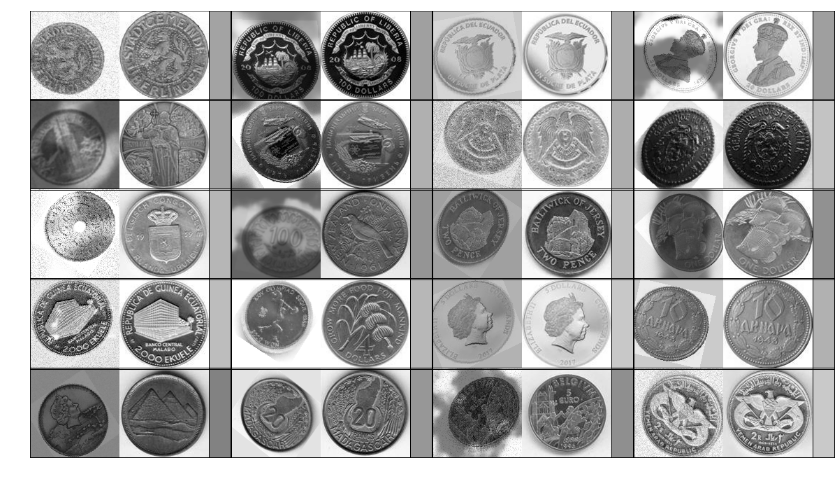

In [15]:
def search(request, max_k=0):
    ind, dist  = dbase.query(request, 3)
    per = np.random.choice(range(len(ind)), len(ind), replace=False)
    im1 = request[per]
    for k in range(0, max_k+1):
        print("Average distance: %.2f" % np.mean(dist[:,k]))
        im2 = dbase.images[ind[:,k]][per]
        sim = 1-dist[:,k][per]
        num = 20
        im1 = im1[:num]
        im2 = im2[:num]
        sim = sim[:num]
        show_similarity(im1, im2, sim, cols=4)

search(augmented)

## Restore

In [6]:
%time
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/007/
